<a href="https://colab.research.google.com/github/MadathalaMounika/METRO/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

In [3]:
file_path = 'data1.csv'
# Read the CSV file into a DataFrame with a specified encoding
try:
    data = pd.read_csv(file_path, encoding='latin1')  # 'latin1' is a common alternative
    # Convert the data into a DataFrame (though it's already a DataFrame by default)
    df = pd.DataFrame(data)

    # Display the DataFrame
    print("Data Representation in DataFrame:")
    print(df.head())  # Displays the first 5 rows

    # Check the structure of the DataFrame
    print("\nDataFrame Information:")
    print(df.info())

except UnicodeDecodeError as e:
    print("Error reading the file:", e)
    print("Try using a different encoding, such as 'utf-16', 'latin1', or 'iso-8859-1'.")

Data Representation in DataFrame:
   Row ID+O6G3A1:R6        Order ID  Order Date   Ship Date       Ship Mode  \
0              4918  CA-2019-160304  01-01-2019  07-01-2019  Standard Class   
1              4919  CA-2019-160304  02-01-2019  07-01-2019  Standard Class   
2              4920  CA-2019-160304  02-01-2019  07-01-2019  Standard Class   
3              3074  CA-2019-125206  03-01-2019  05-01-2019     First Class   
4              8604  US-2019-116365  03-01-2019  08-01-2019  Standard Class   

  Customer ID      Customer Name    Segment        Country          City  ...  \
0    BM-11575      Brendan Murry  Corporate  United States  Gaithersburg  ...   
1    BM-11575      Brendan Murry  Corporate  United States  Gaithersburg  ...   
2    BM-11575      Brendan Murry  Corporate  United States  Gaithersburg  ...   
3    LR-16915       Lena Radford   Consumer  United States   Los Angeles  ...   
4    CA-12310  Christine Abelman  Corporate  United States   San Antonio  ...   

    

In [4]:

df.shape

(5901, 23)

In [5]:
columns_to_remove = ['Row ID+O6G3A1:R6','Order ID',  'Ship Date', 'Ship Mode', 'Customer ID',
                     'Customer Name', 'Payment Mode', 'ind1', 'ind2','Returns']

df1 = df.drop(columns=columns_to_remove, errors='ignore')
print("Updated Dataset after Removing Specified Columns:")
print(df1.head())

Updated Dataset after Removing Specified Columns:
   Order Date    Segment        Country          City       State   Region  \
0  01-01-2019  Corporate  United States  Gaithersburg    Maryland     East   
1  02-01-2019  Corporate  United States  Gaithersburg    Maryland     East   
2  02-01-2019  Corporate  United States  Gaithersburg    Maryland     East   
3  03-01-2019   Consumer  United States   Los Angeles  California     West   
4  03-01-2019  Corporate  United States   San Antonio       Texas  Central   

        Product ID         Category Sub-Category  \
0  FUR-BO-10004709        Furniture    Bookcases   
1  FUR-BO-10004709        Furniture    Bookcases   
2  TEC-PH-10000455       Technology       Phones   
3  OFF-ST-10003692  Office Supplies      Storage   
4  TEC-AC-10002217       Technology  Accessories   

                                        Product Name   Sales  Quantity  \
0  Bush Westfield Collection Bookcases, Medium Ch...   73.94         1   
1  Bush Westfield Co

In [6]:
df1.shape

(5901, 13)

In [7]:
numeric_df = df1.select_dtypes(include=['number'])

quantiles = numeric_df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

print(quantiles)


              0.00     0.05     0.25      0.50     0.75      0.95       0.99  \
Sales        0.836   9.2480  71.9760  128.6480  265.170  956.6648  2396.4000   
Quantity     1.000   1.0000   2.0000    3.0000    5.000    8.0000    10.0000   
Profit   -6599.978 -51.8272   1.7955    8.5025   28.615  168.4384   592.7896   

              1.00  
Sales     9099.930  
Quantity    14.000  
Profit    8399.976  


In [8]:
# Rename the column 'Order Date' to 'Date'
df1.rename(columns={'Order Date': 'Date'}, inplace=True)

# Display the updated DataFrame to confirm the change
print(df1.head())


         Date    Segment        Country          City       State   Region  \
0  01-01-2019  Corporate  United States  Gaithersburg    Maryland     East   
1  02-01-2019  Corporate  United States  Gaithersburg    Maryland     East   
2  02-01-2019  Corporate  United States  Gaithersburg    Maryland     East   
3  03-01-2019   Consumer  United States   Los Angeles  California     West   
4  03-01-2019  Corporate  United States   San Antonio       Texas  Central   

        Product ID         Category Sub-Category  \
0  FUR-BO-10004709        Furniture    Bookcases   
1  FUR-BO-10004709        Furniture    Bookcases   
2  TEC-PH-10000455       Technology       Phones   
3  OFF-ST-10003692  Office Supplies      Storage   
4  TEC-AC-10002217       Technology  Accessories   

                                        Product Name   Sales  Quantity  \
0  Bush Westfield Collection Bookcases, Medium Ch...   73.94         1   
1  Bush Westfield Collection Bookcases, Medium Ch...  173.94         3

In [9]:
df1["Date"].min()


'01-01-2019'

In [10]:
df1["Date"].max()


'31-12-2020'

In [11]:
df1.describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])


,Sales,Quantity,Profit
count,5901.000000,5901.000000,5901.000000
mean,265.345589,3.781901,29.700408
std,474.260645,2.212917,259.589138
min,0.836000,1.000000,-6599.978000
10%,15.992000,2.000000,-15.582600
30%,94.036000,2.000000,3.049800
50%,128.648000,3.000000,8.502500
70%,204.800000,5.000000,21.994500
80%,334.568000,5.000000,39.213000
90%,577.916000,7.000000,87.890000


In [12]:
df1["Sales"].nunique()


5109

In [13]:
import pandas as pd

# Check for missing values in each column
missing_values = df1.isnull().sum()
print(missing_values[missing_values > 0])  # Display only columns with missing values


Series([], dtype: int64)


In [14]:
# Fill missing categorical values with the most frequent value (mode)
categorical_columns = ['Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


<ipython-input-14-9e55dd8a6160>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [15]:
print(df1.isnull().sum())  # Should show 0 missing values


Date            0
Segment         0
Country         0
City            0
State           0
Region          0
Product ID      0
Category        0
Sub-Category    0
Product Name    0
Sales           0
Quantity        0
Profit          0
dtype: int64


In [16]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
categorical_columns = ['Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']

# Apply Label Encoding
label_encoders = {}  # Dictionary to store encoders for inverse transformation later
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df1[col] = label_encoders[col].fit_transform(df1[col])


In [17]:
df1["Date"] = pd.to_datetime(df1["Date"], format="%d-%m-%Y", errors="coerce")

# Check for failed conversions
if df1["Date"].isna().sum() > 0:
    print("Warning: Some dates could not be converted. Check the format!")

# Extract year and month after conversion
df1["Year"] = df1["Date"].dt.year
df1["Month"] = df1["Date"].dt.month



# Calculate sales per quantity (Unit Price)
df1["Sales_per_Quantity"] = df1["Sales"] / df["Quantity"]

# Calculate profit margin
df1["Profit_Margin"] = df1["Profit"] / df["Sales"]

# Convert 'Category' and 'Sub-Category' to string before using .str functions
df1["Category"] = df1["Category"].astype(str).str.strip().str.title()
df1["Sub-Category"] = df1["Sub-Category"].astype(str).str.strip().str.title()

# Clean and standardize city names
df1["City"] = df1["City"].astype(str).str.strip().str.title()

# Group rare cities into 'Other' (appearing less than 10 times)
city_counts = df1["City"].value_counts()
rare_cities = city_counts[city_counts < 10].index
df1["City"] = df1["City"].replace(rare_cities, "Other")

# Display transformed dataset
print(df1.head())


        Date  Segment  Country   City  State  Region       Product ID  \
0 2019-01-01        1        0  Other     18       1  FUR-BO-10004709   
1 2019-01-02        1        0  Other     18       1  FUR-BO-10004709   
2 2019-01-02        1        0  Other     18       1  TEC-PH-10000455   
3 2019-01-03        0        0    227      3       3  OFF-ST-10003692   
4 2019-01-03        1        0    368     41       0  TEC-AC-10002217   

  Category Sub-Category                                       Product Name  \
0        0            4  Bush Westfield Collection Bookcases, Medium Ch...   
1        0            4  Bush Westfield Collection Bookcases, Medium Ch...   
2        2           13                                        GE 30522EE2   
3        1           14  Recycled Steel Personal File for Hanging File ...   
4        2            0                ImationÊClip USBÊflash driveÊ- 8 GB   

    Sales  Quantity   Profit  Year  Month  Sales_per_Quantity  Profit_Margin  
0   73.94    

In [18]:
print(df1.columns)


Index(['Date', 'Segment', 'Country', 'City', 'State', 'Region', 'Product ID',
       'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity',
       'Profit', 'Year', 'Month', 'Sales_per_Quantity', 'Profit_Margin'],
      dtype='object')


In [19]:


### 1️⃣ Reduce Unique Locations (City-State Combination)
location_counts = df1.groupby(["City", "State"]).size()
locations_less_than_10 = location_counts[location_counts < 10]
df1["Location"] = df1.apply(lambda x: "Other" if (x["City"], x["State"]) in locations_less_than_10.index else f"{x['City']}, {x['State']}", axis=1)

# Drop old columns
df1.drop(columns=["City", "State"], inplace=True)

### 2️⃣ Reduce Rare Categories in `Category` and `Sub-Category`
category_counts = df1["Category"].value_counts()
rare_categories = category_counts[category_counts < 10].index
df1["Category"] = df1["Category"].apply(lambda x: "Other" if x in rare_categories else x)

sub_category_counts = df1["Sub-Category"].value_counts()
rare_sub_categories = sub_category_counts[sub_category_counts < 10].index
df1["Sub-Category"] = df1["Sub-Category"].apply(lambda x: "Other" if x in rare_sub_categories else x)

### 3️⃣ Reduce High Cardinality in `Product Name`
product_counts = df1["Product Name"].value_counts()
rare_products = product_counts[product_counts < 5].index
df1["Product Name"] = df1["Product Name"].apply(lambda x: "Other" if x in rare_products else x)

### 4️⃣ Outlier Removal in `Sales`, `Profit`, `Quantity`
df1 = df1[(df1["Sales"] >= df1["Sales"].quantile(0.01)) & (df1["Sales"] <= df1["Sales"].quantile(0.99))]
df1 = df1[(df1["Profit"] >= df1["Profit"].quantile(0.01)) & (df1["Profit"] <= df1["Profit"].quantile(0.99))]
df1 = df1[(df1["Quantity"] >= df1["Quantity"].quantile(0.01)) & (df1["Quantity"] <= df1["Quantity"].quantile(0.99))]

### 5️⃣ Convert `Date` to Year-Month Format to Reduce Uniqueness
df1["Date"] = pd.to_datetime(df1["Date"], dayfirst=True)
df1["YearMonth"] = df1["Date"].dt.to_period("M")
df1.drop(columns=["Date"], inplace=True)  # Drop original date column

### 6️⃣ Drop Irrelevant Columns (if needed)
df1.drop(columns=["Product ID"], inplace=True)  # If Product ID is not useful

# Final dataset shape
print("Final dataset shape:", df1.shape)

# Display cleaned dataset
df1.head(10)


Final dataset shape: (5620, 15)


,Segment,Country,Region,Category,Sub-Category,Product Name,Sales,Quantity,Profit,Year,Month,Sales_per_Quantity,Profit_Margin,Location,YearMonth
0,1,0,1,0,4,"Bush Westfield Collection Bookcases, Medium Ch...",73.940,1,28.2668,2019,1,73.940,0.382294,"Other, 18",2019-01
1,1,0,1,0,4,"Bush Westfield Collection Bookcases, Medium Ch...",173.940,3,38.2668,2019,1,57.980,0.220000,"Other, 18",2019-01
2,1,0,1,2,13,Other,231.980,2,67.2742,2019,1,115.990,0.290000,"Other, 18",2019-01
3,0,0,3,1,14,Other,114.460,2,28.6150,2019,1,57.230,0.250000,"227, 3",2019-01
4,1,0,0,2,0,Other,30.080,2,-5.2640,2019,1,15.040,-0.175000,"368, 41",2019-01
5,1,0,0,2,0,WD My Passport Ultra 1TB Portable External Har...,165.600,3,-6.2100,2019,1,55.200,-0.037500,"368, 41",2019-01
6,1,0,0,2,13,AT&T 17929 Lendline Telephone,180.960,5,13.5720,2019,1,36.192,0.075000,"368, 41",2019-01
7,1,0,0,0,16,Other,1592.850,7,350.4270,2019,1,227.550,0.220000,"Other, 34",2019-01
8,1,0,0,1,3,Storex Dura Pro Binders,11.880,2,5.3460,2019,1,5.940,0.450000,"Other, 34",2019-01
9,1,0,2,2,6,Hewlett Packard 310 Color Digital Copier,959.968,4,119.9960,2019,1,239.992,0.125000,"56, 31",2019-01


In [20]:
def remove_outliers(df1, column):
    mean = df1[column].mean()
    std_dev = df1[column].std()
    return df1[(df1[column] > (mean - std_dev)) & (df1[column] < (mean + std_dev))]

df1 = remove_outliers(df1, "Sales")
df1 = remove_outliers(df1, "Profit")
df1 = remove_outliers(df1, "Quantity")

print(df1.shape)  # New shape after removing outliers


(3128, 15)


In [21]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["Segment", "Category", "Sub-Category", "Region", "Location"]
encoder = LabelEncoder()

for col in categorical_cols:
    df1[col] = encoder.fit_transform(df1[col])

print(df1.head())  # Check the transformed dataset


   Segment  Country  Region  Category  Sub-Category  \
1        1        0       1         0            11   
3        0        0       3         1             6   
4        1        0       0         2             0   
5        1        0       0         2             0   
6        1        0       0         2             5   

                                        Product Name   Sales  Quantity  \
1  Bush Westfield Collection Bookcases, Medium Ch...  173.94         3   
3                                              Other  114.46         2   
4                                              Other   30.08         2   
5  WD My Passport Ultra 1TB Portable External Har...  165.60         3   
6                      AT&T 17929 Lendline Telephone  180.96         5   

    Profit  Year  Month  Sales_per_Quantity  Profit_Margin  Location YearMonth  
1  38.2668  2019      1              57.980         0.2200       125   2019-01  
3  28.6150  2019      1              57.230         0.2500    

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Ensure "Sales" column exists and use it as the target variable
df1.columns = df1.columns.astype(str).str.strip()

if "Sales" in df1.columns:
    X = df1.drop(columns="Sales")  # Features
    y = df1["Sales"]  # Target variable
else:
    raise KeyError("Column 'Sales' not found in df1. Check dataset loading and column names.")

# Handle missing values
X_numeric = X.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X_numeric)
X[X_numeric.columns] = X_imputed

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# PCA for dimensionality reduction
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Reshape for RNN models
X_train_rnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def build_ann():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def build_rnn():
    model = Sequential([
        SimpleRNN(100, activation='relu', return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)),
        Dropout(0.3),
        SimpleRNN(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def build_lstm():
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)),
        Dropout(0.3),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

def build_gru():
    model = Sequential([
        GRU(100, activation='relu', return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)),
        Dropout(0.3),
        GRU(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Train models
models = {
    "ANN": build_ann(),
    "RNN": build_rnn(),
    "LSTM": build_lstm(),
    "GRU": build_gru()
}

results = {}
best_accuracy = 0
best_model = None

for name, model in models.items():
    print(f"Training {name} model...")
    if name == "ANN":
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_rnn, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test_rnn, y_test), callbacks=[early_stopping])
        y_pred = model.predict(X_test_rnn)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    accuracy = 100 - mape

    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2, "MAPE": mape, "Accuracy": accuracy}
    print(f"{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = name

print(f"\nBest Model: {best_model} with Accuracy: {best_accuracy:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training ANN model...
Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 22518.6504 - mae: 117.0137 - val_loss: 23616.8027 - val_mae: 119.3731
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19189.7207 - mae: 112.6096 - val_loss: 21643.8945 - val_mae: 116.9959
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 18431.5586 - mae: 112.1900 - val_loss: 19273.7637 - val_mae: 113.7588
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16884.3320 - mae: 109.7499 - val_loss: 16918.5137 - val_mae: 110.9771
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 14327.9434 - mae: 102.9961 - val_loss: 14927.5752 - val_mae: 109.1961
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12338.2627 - mae: 97.4501 - val_loss: 12584.3877 - val_mae: 103.9048
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9165.0957 - mae: 86.6952 - val_loss: 10024.5850 - val_mae: 94.9258
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7941.2168 - mae: 81.9007 - v

In [23]:
import pandas as pd
import numpy as np
import plotly.express as px

# Check if models exist before using them
if 'models' in globals():
    print("Models exist:", models.keys())
else:
    raise NameError("The 'models' dictionary is not defined. Ensure the training script is executed first.")

# Ensure best_model is valid
if best_model not in models:
    raise ValueError(f"Invalid best_model: {best_model}. Available models: {models.keys()}")

# Ensure 'Predicted Sales' column does not already exist to avoid overwriting issues
if 'Predicted Sales' in df1.columns:
    df1 = df1.drop(columns=['Predicted Sales'])

# Check shape compatibility before predicting
if X_pca.shape[1] != X_train.shape[1]:
    raise ValueError(f"Mismatch in input shape. X_pca shape: {X_pca.shape}, Expected: {X_train.shape}")

# Make predictions and ensure the shape is correct
df1['Predicted Sales'] = models[best_model].predict(X_pca).flatten()

# Print confirmation
print("Predictions added successfully to df1.")

# Generate a 3D scatter plot
fig = px.scatter_3d(
    df1,
    x='Category',
    y='Sub-Category',
    z='Product Name',
    color='Predicted Sales',
    size='Quantity',
    hover_data=['Profit', 'Sales'],
    title=f"3D Sales Prediction using {best_model} Model"
)

# Show plot
fig.show()


Models exist: dict_keys(['ANN', 'RNN', 'LSTM', 'GRU'])
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Predictions added successfully to df1.


In [ ]:
# Define the file path in Google Drive
file_path = "/content/drive/MyDrive/Colab Notebooks/sales_data.csv"

# Save df1 to CSV
df1.to_csv(file_path, index=False)

# Print confirmation
print(f"Data saved successfully to {file_path}")


Data saved successfully to /content/drive/MyDrive/Colab Notebooks/sales_data.csv


In [ ]:
df1.head(8)

,Segment,Country,Region,Category,Sub-Category,Product Name,Sales,Quantity,Profit,Year,Month,Sales_per_Quantity,Profit_Margin,Location,YearMonth,Predicted Sales
1,1,0,1,0,11,"Bush Westfield Collection Bookcases, Medium Ch...",173.940,3,38.2668,2019,1,57.980,0.2200,125,2019-01,181.413742
3,0,0,3,1,6,Other,114.460,2,28.6150,2019,1,57.230,0.2500,38,2019-01,115.395508
4,1,0,0,2,0,Other,30.080,2,-5.2640,2019,1,15.040,-0.1750,76,2019-01,34.892895
5,1,0,0,2,0,WD My Passport Ultra 1TB Portable External Har...,165.600,3,-6.2100,2019,1,55.200,-0.0375,76,2019-01,159.981949
6,1,0,0,2,5,AT&T 17929 Lendline Telephone,180.960,5,13.5720,2019,1,36.192,0.0750,76,2019-01,144.919617
8,1,0,0,1,10,Storex Dura Pro Binders,11.880,2,5.3460,2019,1,5.940,0.4500,138,2019-01,10.406581
13,1,0,2,1,9,Other,5.248,2,0.5904,2019,1,2.624,0.1125,22,2019-01,10.587373
14,1,0,2,2,5,Other,59.184,2,5.1786,2019,1,29.592,0.0875,22,2019-01,50.746262


In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

def predict_sales_ann(model, df, category, sub_category, product_name, scaler, pca):
    """
    Predicts the sales of a given product using the trained ANN model.

    Parameters:
    - model (Sequential): The trained ANN model.
    - df (DataFrame): The dataset containing product details.
    - category (str/int): The category of the product.
    - sub_category (str/int): The sub-category of the product.
    - product_name (str): The product name.
    - scaler (StandardScaler): The fitted scaler used for standardization.
    - pca (PCA): The fitted PCA model for dimensionality reduction.

    Returns:
    - Predicted sales value.
    """
    # Filter the product data
    product_df = df[
        (df['Category'] == category) &
        (df['Sub-Category'] == sub_category) &
        (df['Product Name'] == product_name)
    ]

    if product_df.empty:
        return f"No data found for {product_name} in Category: {category}, Sub-Category: {sub_category}"

    # Define expected features (excluding Sales column)
    feature_columns = ['Segment', 'Country', 'Region', 'Category', 'Sub-Category',
                       'Quantity', 'Profit', 'Year', 'Month', 'Sales_per_Quantity',
                       'Profit_Margin', 'Location']

    # Select only relevant features and handle missing values
    X_numeric = product_df[feature_columns]

    # Handle missing values
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X_numeric)

    # Apply standardization
    X_scaled = scaler.transform(X_imputed)

    # Apply PCA
    X_pca = pca.transform(X_scaled)

    # Predict sales
    sales_prediction = model.predict(X_pca)

    return f"Predicted Sales for {product_name}: {sales_prediction[0][0]:.2f}"

# Example usage
category_input = 1
sub_category_input = 10
product_name_input = "Storex Dura Pro Binders"

predicted_sales = predict_sales_ann(models["ANN"], df1, category_input, sub_category_input, product_name_input, scaler, pca)
print(predicted_sales)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Sales for Storex Dura Pro Binders: 10.41


In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

def predict_sales_ann_m(model, df, category, sub_category, product_name, scaler, pca, quantity_input, months_ahead=3):
    """
    Predicts the sales of a given product using the trained ANN model for the next N months with a variable quantity.

    Parameters:
    - model (Sequential): The trained ANN model.
    - df (DataFrame): The dataset containing product details.
    - category (str/int): The category of the product.
    - sub_category (str/int): The sub-category of the product.
    - product_name (str): The product name.
    - scaler (StandardScaler): The fitted scaler used for standardization.
    - pca (PCA): The fitted PCA model for dimensionality reduction.
    - quantity_input (int/float): The quantity input for prediction.
    - months_ahead (int): Number of months to predict into the future.

    Returns:
    - Predicted sales values for the next N months.
    """
    # Filter the product data
    product_df = df[
        (df['Category'] == category) &
        (df['Sub-Category'] == sub_category) &
        (df['Product Name'] == product_name)
    ]

    if product_df.empty:
        return f"No data found for {product_name} in Category: {category}, Sub-Category: {sub_category}"

    # Define expected features (excluding Sales column)
    feature_columns = ['Segment', 'Country', 'Region', 'Category', 'Sub-Category',
                       'Quantity', 'Profit', 'Year', 'Month', 'Sales_per_Quantity',
                       'Profit_Margin', 'Location']

    # Select only relevant features and handle missing values
    X_numeric = product_df[feature_columns]

    # Handle missing values
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X_numeric)

    # Get the latest month and year from the data
    last_year = int(X_numeric['Year'].max())
    last_month = int(X_numeric['Month'].max())

    # Generate predictions for the next 'months_ahead' months
    predictions = []
    for i in range(1, months_ahead + 1):
        # Compute new month and year
        new_month = last_month + i
        new_year = last_year

        if new_month > 12:
            new_year += (new_month - 1) // 12
            new_month = (new_month - 1) % 12 + 1  # Ensure months are between 1-12

        X_future = X_numeric.copy()
        X_future['Month'] = new_month
        X_future['Year'] = new_year  # Assign new year correctly
        X_future['Quantity'] = quantity_input  # Use variable input quantity

        # Apply standardization
        X_scaled = scaler.transform(imputer.transform(X_future))

        # Apply PCA
        X_pca = pca.transform(X_scaled)

        # Predict sales
        sales_prediction = model.predict(X_pca)
        predictions.append((new_year, new_month, sales_prediction[0][0]))

    return predictions

# Example usage
category_input = 1
sub_category_input = 10
product_name_input = "Storex Dura Pro Binders"
quantity_input = 5  # Example variable quantity

predicted_sales = predict_sales_ann_m(models["ANN"], df1, category_input, sub_category_input, product_name_input, scaler, pca, quantity_input, months_ahead=3)
for year, month, sales in predicted_sales:
    print(f"Predicted Sales for {product_name_input} with quantity {quantity_input} in {year}-{int(month):02d}: {sales:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted Sales for Storex Dura Pro Binders with quantity 5 in 2021-01: 37.94
Predicted Sales for Storex Dura Pro Binders with quantity 5 in 2021-02: 38.41
Predicted Sales for Storex Dura Pro Binders with quantity 5 in 2021-03: 39.07


In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer

def predict_sales_ann_y(model, df, category, sub_category, product_name, quantity_input, scaler, pca, years_ahead=3):
    """
    Predicts the sales, quantity, and profit of a given product using the trained ANN model for the next N years.

    Parameters:
    - model (Sequential): The trained ANN model.
    - df (DataFrame): The dataset containing product details.
    - category (str/int): The category of the product.
    - sub_category (str/int): The sub-category of the product.
    - product_name (str): The product name.
    - quantity_input (int): The input quantity which influences sales and profit predictions.
    - scaler (StandardScaler): The fitted scaler used for standardization.
    - pca (PCA): The fitted PCA model for dimensionality reduction.
    - years_ahead (int): Number of years to predict into the future.

    Returns:
    - Predicted sales, quantity, and profit values for the next N years.
    """
    # Filter the product data
    product_df = df[
        (df['Category'] == category) &
        (df['Sub-Category'] == sub_category) &
        (df['Product Name'] == product_name)
    ]

    if product_df.empty:
        return f"No data found for {product_name} in Category: {category}, Sub-Category: {sub_category}"

    # Define expected features (excluding Sales column)
    feature_columns = ['Segment', 'Country', 'Region', 'Category', 'Sub-Category',
                       'Quantity', 'Profit', 'Year', 'Month', 'Sales_per_Quantity',
                       'Profit_Margin', 'Location']

    # Select only relevant features and handle missing values
    X_numeric = product_df[feature_columns]

    # Handle missing values
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X_numeric)

    # Get the last known year and month
    last_year = int(X_numeric['Year'].max())
    last_month = int(X_numeric['Month'].max())

    # Generate predictions for the next 'years_ahead' years (36 months)
    predictions = []

    for i in range(1, years_ahead * 12 + 1):
        # Increment month
        last_month += 1

        # If month exceeds 12, reset to 1 and increment year
        if last_month > 12:
            last_month = 1
            last_year += 1

        # Create future features
        X_future = X_numeric.copy()
        X_future['Month'] = last_month
        X_future['Year'] = last_year
        X_future['Quantity'] = quantity_input  # Use input quantity value

        # Apply standardization
        X_scaled = scaler.transform(imputer.transform(X_future))

        # Apply PCA
        X_pca = pca.transform(X_scaled)

        # Predict sales and profit based on quantity
        sales_prediction = model.predict(X_pca)
        profit_prediction = quantity_input * X_future.iloc[0]['Profit_Margin']

        predictions.append((last_year, last_month, X_future.iloc[0]['Region'], sales_prediction[0][0], quantity_input, profit_prediction))

    return predictions

# Example usage
category_input = 1
sub_category_input = 10
product_name_input = "Storex Dura Pro Binders"
quantity_input = 5  # Variable input quantity

years_ahead = 3
predicted_sales = predict_sales_ann_y(models["ANN"], df1, category_input, sub_category_input, product_name_input, quantity_input, scaler, pca, years_ahead=years_ahead)

# Print predictions only once
printed_predictions = set()
for year, month, region, sales, quantity, profit in predicted_sales:
    prediction_text = f"Predicted Sales for {product_name_input} in {year}-{int(month):02d} (Region: {region}): Sales: {sales:.2f}, Profit: {profit:.2f}"
    if prediction_text not in printed_predictions:
        print(prediction_text)
        printed_predictions.add(prediction_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# Convert results dictionary to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# 3D Scatter Plot using Plotly
fig = px.scatter_3d(results_df,
                     x="Accuracy",
                     y="R²",
                     z="RMSE",
                     text=results_df.index,  # Model names as labels
                     color="Accuracy",
                     title="Model Performance Comparison",
                     labels={"Accuracy": "Accuracy (%)", "R²": "R² Score", "RMSE": "Root Mean Squared Error"},
                     size_max=10)

fig.update_layout(scene=dict(
                    xaxis_title='Accuracy (%)',
                    yaxis_title='R² Score',
                    zaxis_title='RMSE'
                ))

fig.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


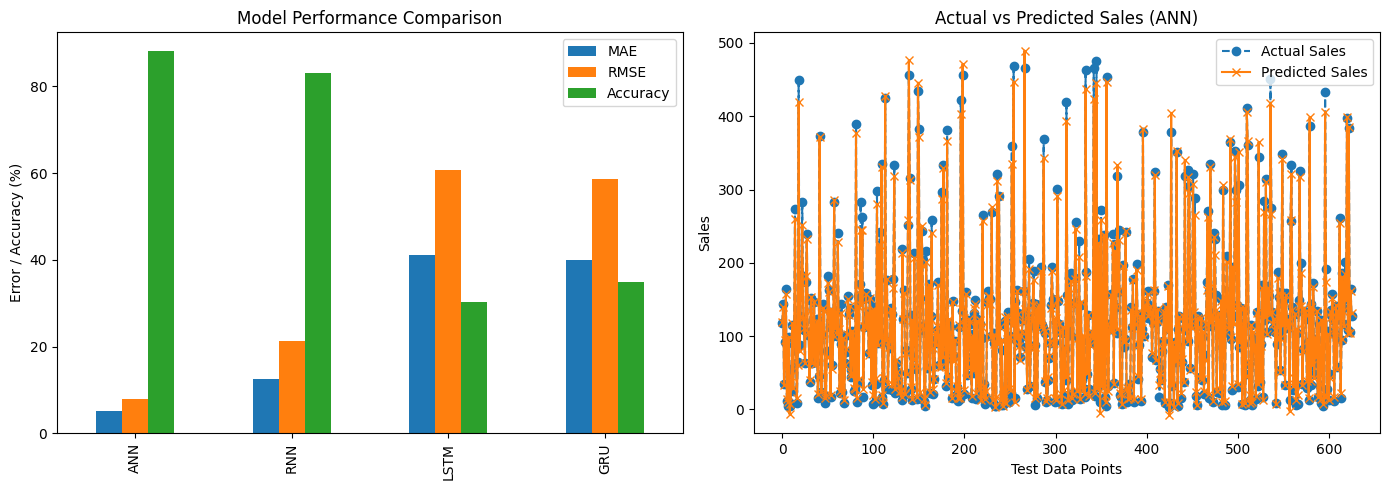

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Model Performance
def plot_model_performance(results):
    df_results = pd.DataFrame(results).T  # Convert dictionary to DataFrame

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar Plot for MAE, RMSE, Accuracy
    df_results[['MAE', 'RMSE', 'Accuracy']].plot(kind='bar', ax=axes[0])
    axes[0].set_title("Model Performance Comparison")
    axes[0].set_ylabel("Error / Accuracy (%)")
    axes[0].legend(loc='best')

    # Line Plot for Actual vs Predicted (Best Model)
    best_model_preds = models[best_model].predict(X_test if best_model == "ANN" else X_test_rnn)
    axes[1].plot(y_test.values, label="Actual Sales", marker="o", linestyle="dashed")
    axes[1].plot(best_model_preds, label="Predicted Sales", marker="x", linestyle="solid")
    axes[1].set_title(f"Actual vs Predicted Sales ({best_model})")
    axes[1].set_ylabel("Sales")
    axes[1].set_xlabel("Test Data Points")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot results
plot_model_performance(results)





In [25]:
import pickle

# Save the trained ANN model
with open('sales_forecasting_ann_model.pkl', 'wb') as f:
    pickle.dump(models["ANN"], f)

# Save the scaler
with open('sales_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the PCA model
with open('sales_pca.pkl', 'wb') as f:
    pickle.dump(pca, f)


In [26]:
import pickle

# Load the trained ANN model
with open('/content/drive/MyDrive/Colab Notebooks/sales_forecasting_ann_model.pkl', 'rb') as f:
    ann_model = pickle.load(f)


# Print confirmation
print("Models loaded successfully!")


Models loaded successfully!


In [27]:
import json

# Save column information
columns_info = {
    'data_columns': [col.lower() for col in df1.columns],  # Store column names in lowercase
    'feature_columns': ['Segment', 'Country', 'Region', 'Category', 'Sub-Category',
                         'Product Name	','Quantity', 'Profit', 'Year', 'Month', 'Sales_per_Quantity',
                         'Profit_Margin', 'Location']  # List of features used in the model
}

with open("columns.json", "w") as f:
    json.dump(columns_info, f, indent=4)

# Save unique location data (if needed)
unique_locations = df1['Location'].dropna().unique().tolist()

with open("locations.json", "w") as f:
    json.dump({'locations': unique_locations}, f, indent=4)


In [28]:
!pip install flask
!pip install flask_ngrok
!pip install pyngrok==4.1.1



  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15963 sha256=a6c4ebb090645732f955dea99451efad563ff30b977c72ab4501be8de882b515
  Stored in directory: /root/.cache/pip/wheels/f4/e2/28/275496a22cb15fb495458aed2b164b4ccaa10e2f44188fb0b9
Successfully built pyngrok


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
from flask import Flask, render_template


In [32]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))


https://5000-m-s-eeui97oqfprr-a.us-east4-1.prod.colab.dev


In [33]:
import numpy as np
import pickle
import pandas as pd
from flask import Flask, request, render_template
from sklearn.impute import SimpleImputer
from google.colab.output import eval_js  # Use eval_js for Colab proxy

# Define template and static folder paths
template_folder = "/content/drive/MyDrive/Colab Notebooks/templates"
static_folder = "/content/drive/MyDrive/Colab Notebooks/static"

app = Flask(__name__, template_folder=template_folder, static_folder=static_folder)

# Load trained model, scaler, and PCA
model_path = "/content/drive/MyDrive/Colab Notebooks/sales_forecasting_ann_model.pkl"
scaler_path = "/content/drive/MyDrive/Colab Notebooks/sales_scaler.pkl"
pca_path = "/content/drive/MyDrive/Colab Notebooks/sales_pca.pkl"

with open(model_path, 'rb') as f:
    model = pickle.load(f)

with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

with open(pca_path, 'rb') as f:
    pca = pickle.load(f)

# Load dataset
df_path = "/content/drive/MyDrive/Colab Notebooks/sales_data.csv"
df = pd.read_csv(df_path)

# Prediction function with future year support
def predict_sales_ann(model, df, category, sub_category, product_name, year, scaler, pca):
    product_df = df[
        (df['Category'] == category) &
        (df['Sub-Category'] == sub_category) &
        (df['Product Name'] == product_name)
    ]

    if product_df.empty:
        return f"No data found for {product_name} in Category: {category}, Sub-Category: {sub_category}"

    # Feature columns used for prediction
    feature_columns = ['Segment', 'Country', 'Region', 'Category', 'Sub-Category',
                       'Quantity', 'Profit', 'Year', 'Month', 'Sales_per_Quantity',
                       'Profit_Margin', 'Location']

    X_numeric = product_df[feature_columns]

    # Replace the year with the input future year
    X_numeric['Year'] = year

    # Handle missing values
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X_numeric)

    # Apply scaling and PCA transformation
    X_scaled = scaler.transform(X_imputed)
    X_pca = pca.transform(X_scaled)

    # Make prediction
    sales_prediction = model.predict(X_pca)

    return f"Predicted Sales for {year}: {sales_prediction[0][0]:.2f}"

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/getprediction', methods=['POST'])
def getprediction():
    try:
        category = int(request.form['category'])
        sub_category = int(request.form['sub_category'])
        product_name = request.form['product_name']
        year = int(request.form['year'])

        prediction = predict_sales_ann(model, df, category, sub_category, product_name, year, scaler, pca)

        return render_template('index.html', output=prediction)

    except Exception as e:
        return render_template('index.html', output=f"Error: {str(e)}")

if __name__ == "__main__":
    from threading import Thread
    import time

    def run_flask():
        app.run(port=5000, debug=False, use_reloader=False)

    # Start Flask in a separate thread
    thread = Thread(target=run_flask)
    thread.start()

    # Wait a few seconds to allow Flask to start
    time.sleep(3)

    # Get the Colab proxy URL
    colab_url = eval_js("google.colab.kernel.proxyPort(5000)")
    print(f"Your app is running at: {colab_url}")


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


Your app is running at: https://5000-m-s-eeui97oqfprr-a.us-east4-1.prod.colab.dev
